# XSOR Project - task 2: Trending asset into mean reverting asset

Trending assets are those whose prices or returns display a sustained movement in one direction (upward or
downward) over time. Trending assets are typically non-stationary, meaning their statistical properties (e.g.,
mean, variance) evolve over time. This poses challenges for many standard financial analyses, which assume
stationarity.

In this part of the project, instead of analyzing an already mean-reverting asset, our task was to transform a
trending financial asset into one that exhibits mean-reverting behavior through mathematical or statistical normalization
techniques.

## Graphical introduction: heikin ashi candlestick plot

**OHLC Data** (Open, High, Low, Close) is a format in financial data analysis that captures key price points of an
asset for a given timeframe (e.g., minute, hour, day). Similar to a bar chart, an OHLC candlestick chart displays
the market’s opening, highest, lowest, and last prices for a given timeframe. The candlestick comprises a broader
section known as the ”real body.”

This real body signifies the price range between the opening and closing prices.  
If the real body is filled or colored <span style="color:red;"><b>red</b></span>, it signifies that the closing price was lower than the opening price.  
Conversely, when the real body is <span style="color:green;"><b>green</b></span>, it indicates that the closing price exceeded the opening price.

"""
<p align="center">
  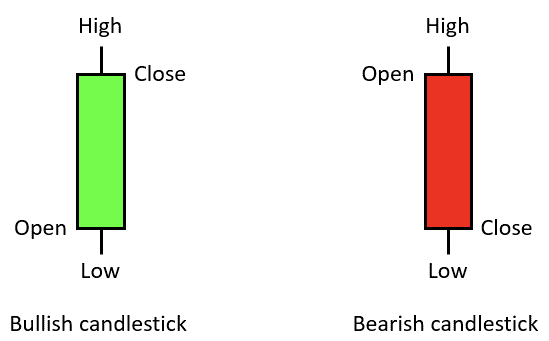
</p>
"""

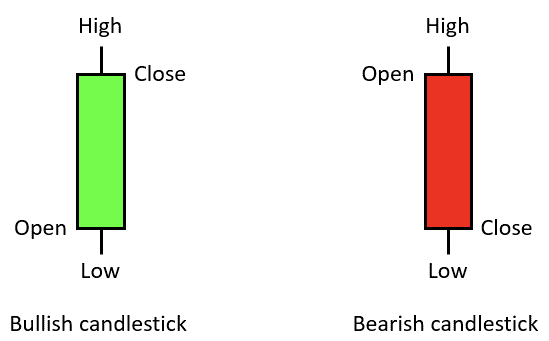

**Heiken- Ashi**: A useful way to visualize trends is by mean of Heiken-Ashi candlesticks. Heiken Ashi (HA) is
a modified candlestick charting technique used in technical analysis to smooth out price action and highlight
trends more clearly. It modifies the traditional Open, High, Low, Close (OHLC) data with a specific formula,
creating a visual representation that filters out some market noise.
The Heiken Ashi (HA) values are calculated as follows:

#### HA Close:
$$
HA\_Close_t = \frac{Open_t + High_t + Low_t + Close_t}{4}
$$

#### HA Open:
$$
HA\_Open_t = \frac{HA\_Open_{t-1} + HA\_Close_{t-1}}{2}
$$
For the first period, the standard \( Open_t \) is used as the starting value.

#### HA High:
$$
HA\_High_t = \max(High_t, HA\_Open_t, HA\_Close_t)
$$

#### HA Low:
$$
HA\_Low_t = \min(Low_t, HA\_Open_t, HA\_Close_t)
$$

HA candles are useful for identifying trends and reversal signals. At a high level, they can be interpreted as follows:

- **Bullish Trends:** Candles with large bodies and no lower wicks typically indicate strong upward trends.
- **Bearish Trends:** Candles with large bodies and no upper wicks typically indicate strong downward trends.
- **Reversal Signals:** Small bodies with both upper and lower wicks may indicate a potential reversal or consolidation.


Here is an example graph:

![An example of trending asset](Fig/trades2.png "An example of trending asset")

However, for the future analysis, we will focus only on Closing Prices, as they are less aftected by daily fluctuactions (add resasons ?????)

## Part 1: A metric for mean reversion

### What is mean reversion ?

![An example of trending asset](Fig/closing_prices_plot.png "An example of trending asset") **Figure 3:** An example of a trending asset

A **Trending asset** is an asset whose prices or returns tend to move back toward their historical average or mean over time.

A typical example is the Ornstein-Uhlenbeck process, which models mean-reverting behavior. The equation for the O-U process is:

$$
dX_t = \theta (\mu - X_t) dt + \sigma dW_t
$$

The solution to this SDE is given by:

$$
X_t = X_0 e^{-\theta t} + \mu \left( 1 - e^{-\theta t} \right) + \sigma \int_0^t e^{-\theta(t-s)} dW_s
$$


Where:
- $ X_t $ is the asset price (or return) at time $ t $,
- $ \mu $ is the long-term mean of the process,
- $ \theta $ is the rate at which the process reverts to the mean (also called the speed of mean reversion),
- $ \sigma $ is the volatility of the process,
- $ dW_t $ is a Wiener process or Brownian motion term representing random noise.


<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/var/folders/sq/hv1_dwz10cx9mcwy54fj3st40000gn/T/ipykernel_63517/1262624877.py:32: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(mu, color="green", linestyle="--", label="Long-term Mean ($\mu$)")


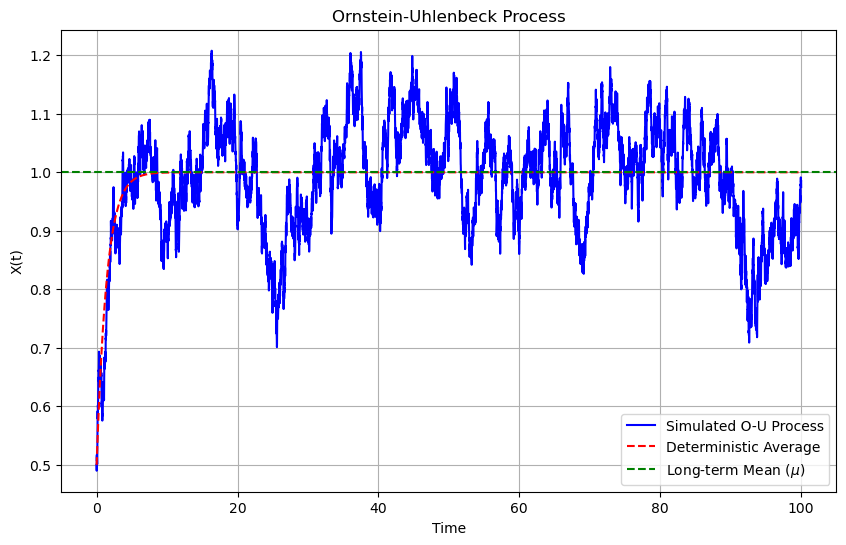

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Ornstein-Uhlenbeck process
theta = 0.7     # rate of mean reversion
mu = 1.0        # long-term mean
sigma = 0.1     # volatility
X0 = 0.5        # initial value
T = 100          # total time
dt = 0.01       # time step
n_steps = int(T / dt)  # number of steps

# Time array
time = np.linspace(0, T, n_steps)

# Initialize the array to store the process values
X = np.zeros(n_steps)
X[0] = X0

# Simulate the Ornstein-Uhlenbeck process
for t in range(1, n_steps):
    dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion increment
    X[t] = X[t-1] + theta * (mu - X[t-1]) * dt + sigma * dW

# Analytical solution for comparison
X_analytical = X0 * np.exp(-theta * time) + mu * (1 - np.exp(-theta * time))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, X, label="Simulated O-U Process", color="blue")
plt.plot(time, X_analytical, label="Deterministic Average", color="red", linestyle='dashed')
plt.axhline(mu, color="green", linestyle="--", label="Long-term Mean ($\mu$)")
plt.title("Ornstein-Uhlenbeck Process")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()
plt.grid(True)
plt.show()

Developing a metric for mean reversion is the task of group 1. We will focus instead on predifined test to determine if our dataset is trending or not in a given timewindow. In a second moment we will implement an algorithm to cancel this trend.

### Statistical tests

#### **Hurst exponent**

The **Hurst exponent**, denoted as $ H $, is a statistical measure used to evaluate the long-term memory of time series data. It helps in understanding the behavior of financial time series, indicating whether they are mean-reverting, trending, or following a random walk.

### Interpretation of Hurst Exponent Values

The value of the Hurst exponent ranges from 0 to 1 and can be interpreted as follows:

- *$$ H < 0.5 $$*: Indicates **mean-reverting behavior**. This suggests that the time series tends to revert back to its average over time. For example, a stock price that oscillates around its mean without sustaining a prolonged trend would exhibit this behavior.
  
- *$$ H = 0.5 $$*: Suggests that the time series behaves like a **Geometric Brownian Motion**, implying no clear trend and resembling a random walk.

- *$$ H > 0.5 $$*: Indicates **trending behavior**. In this case, high values are likely to be followed by more high values, suggesting persistence in the direction of movement.

### Mathematical Background

The Hurst exponent is defined mathematically in terms of the rescaled range $ R(n) $ and standard deviation $ S(n) $ of the time series:

$$
\mathbb{E}\left[\frac{R(n)}{S(n)}\right] = C n^H \quad \text{as } n \to \infty
$$


Where:
- $ R(n) $: The range of the first $ n $ cumulative deviations from the mean.
- $ S(n) $: The standard deviation of the first $ n $ observations.
- $ C $: A constant.

### Applications in Financial Markets

In finance, the Hurst exponent can be used to develop trading strategies based on whether a market is trending or mean-reverting. Traders can capitalize on mean-reverting behavior by buying low and selling high when prices deviate from their average.

Understanding the Hurst exponent is crucial for analyzing market behavior and making informed trading decisions based on statistical properties of financial time series data.

## Issues

We found out that the Hurst exponent can't be considered as a reliable measure of mean revertness. In fact it measures long term behaviors of the time series, but these don't necessary concide with mean-revertness.

An example is provided below, where various sinosoidal timeseries have been generated and trend/ noise has been added to some of them.
Finally the relative Hurst exponents have been computed over a timewindow of N=5000 timesteps, but 

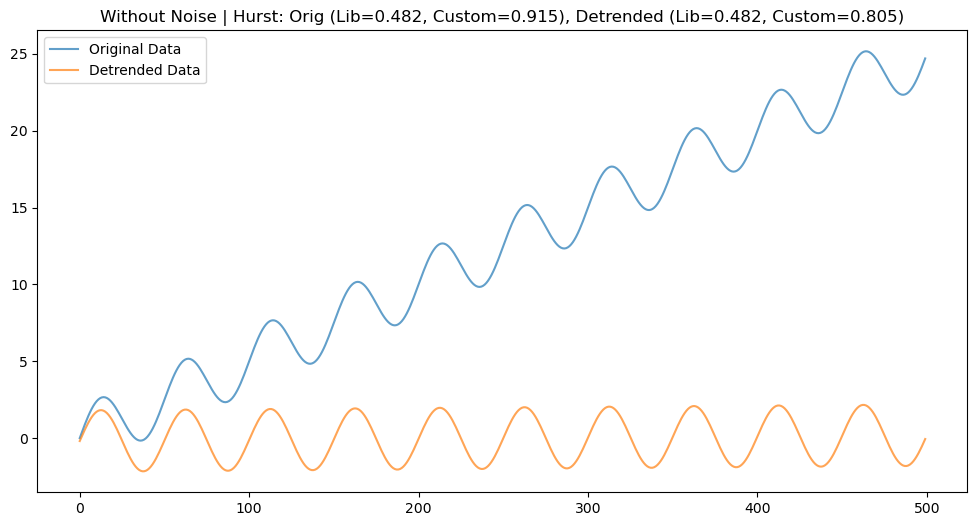

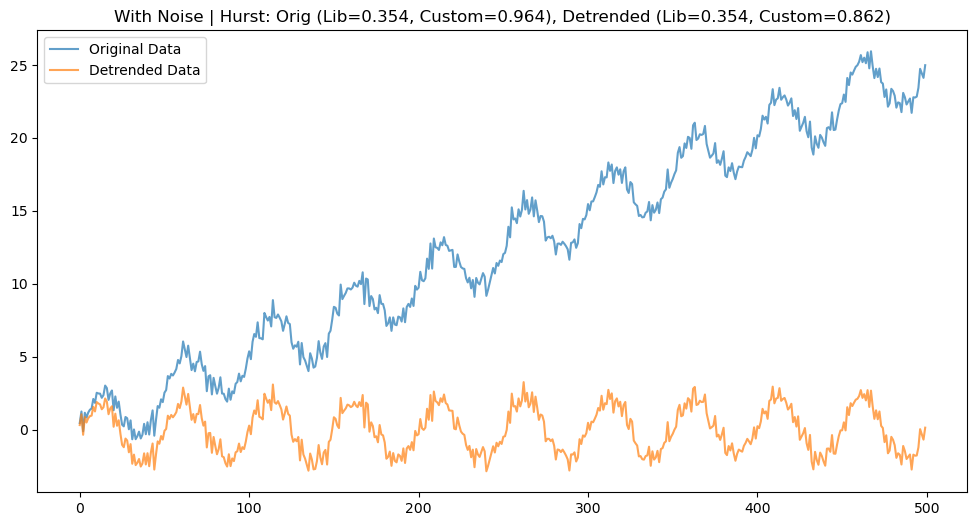

In [21]:
#Trial for final explaination

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from hurst import compute_Hc

def hurst_exponent(time_series, min_window=10, max_window=100):
    """
    Estimate the Hurst exponent of a time series using Rescaled Range (R/S) analysis.
    
    Parameters:
    - time_series: array-like, the time series to analyze.
    - min_window: int, minimum segment size (m).
    - max_window: int, maximum segment size (m).
    
    Returns:
    - H: float, the estimated Hurst exponent.
    """
    N = len(time_series)
    rs_values = []
    window_sizes = []

    for window_size in range(min_window, min(max_window, N // 2)):
        window_sizes.append(window_size)
        num_windows = N // window_size
        rs_for_window = []

        for i in range(num_windows):
            # Extract the window
            segment = time_series[i * window_size:(i + 1) * window_size]
            
            # Calculate mean and cumulative deviation
            mean = np.mean(segment)
            cumulative_deviation = np.cumsum(segment - mean)
            
            # Calculate range (R) and standard deviation (S)
            R = np.max(cumulative_deviation) - np.min(cumulative_deviation)
            S = np.std(segment)
            
            if S > 0:
                rs_for_window.append(R / S)

        # Average R/S across all windows
        if rs_for_window:
            rs_values.append(np.mean(rs_for_window))

    # Fit a line to log-log plot to estimate H
    log_window_sizes = np.log(window_sizes)
    log_rs_values = np.log(rs_values)
    H, _ = np.polyfit(log_window_sizes, log_rs_values, 1)

    return H

def generate_series(n, trend_slope=0.1, oscillation_amplitude=1.0, noise_level=0.0):
    t = np.arange(n)
    trend = trend_slope * t
    oscillation = oscillation_amplitude * np.sin(2 * np.pi * t / 50)
    noise = np.random.normal(scale=noise_level, size=n)
    return trend + oscillation + noise

def linear_detrend(series):
    t = np.arange(len(series))
    slope, intercept, _, _, _ = linregress(t, series)
    return series - (slope * t + intercept)

def analyze_series(data, title_prefix):
    hurst_lib, _, _ = compute_Hc(data, kind='random_walk', simplified=False)
    hurst_custom = hurst_exponent(data)
    detrended_data = linear_detrend(data)
    hurst_lib_detrended, _, _ = compute_Hc(detrended_data, kind='random_walk', simplified=False)
    hurst_custom_detrended = hurst_exponent(detrended_data)
    
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Original Data", alpha=0.7)
    plt.plot(detrended_data, label="Detrended Data", alpha=0.7)
    plt.legend()
    plt.title(f"{title_prefix} | Hurst: Orig (Lib={hurst_lib:.3f}, Custom={hurst_custom:.3f}), "
              f"Detrended (Lib={hurst_lib_detrended:.3f}, Custom={hurst_custom_detrended:.3f})")
    plt.show()

np.random.seed(42)
N=500 #length of time series
data_clean = generate_series(N, trend_slope=0.05, oscillation_amplitude=2.0, noise_level=0.0)
analyze_series(data_clean, "Without Noise")
data_noisy = generate_series(N, trend_slope=0.05, oscillation_amplitude=2.0, noise_level=0.5)
analyze_series(data_noisy, "With Noise")